# Análise de dados - Curva característica do diodo e do painel solar

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from scipy.optimize import curve_fit
from scipy.constants import e, k

In [2]:
plt.rcParams['figure.figsize'] = (10, 8)
plt.rcParams['figure.facecolor'] = 'white'
sns.set_theme()

## Diodo

In [3]:
df_diodo = pd.read_csv('./Dados/diodo.csv')

In [68]:
df_diodo['sCorrente'] = df_diodo['Corrente'] * 0 + 5E-6
df_diodo['sTensao B'] = df_diodo['Corrente'] * 0 + 5E-6

In [69]:
df_diodo.describe()

,Tempo,Tensao A,Tensao B,Corrente,sCorrente,sTensao B
count,369.000000,369.000000,369.000000,3.690000e+02,369.000000,369.000000
mean,9.200000,0.055600,1.568553,1.684702e-04,0.000005,0.000005
std,5.333268,0.087101,0.861819,2.638973e-04,0.000000,0.000000
min,0.000000,0.000156,0.037000,4.730000e-07,0.000005,0.000005
25%,4.600000,0.000436,0.799000,1.320000e-06,0.000005,0.000005
50%,9.200000,0.000726,1.644000,2.200000e-06,0.000005,0.000005
75%,13.800000,0.131000,2.512000,3.960000e-04,0.000005,0.000005
max,18.400000,0.208000,2.537000,6.290000e-04,0.000005,0.000005


In [70]:
R = 330.2, 0.1	# Resistência e incerteza

In [173]:
df_fit = df_diodo.loc[(df_diodo['Tensao B'] > 2.30) & (df_diodo['Tensao B'] < 2.55)]

In [174]:
popt, pcov = curve_fit(
	lambda x, I, b: I * (np.exp(b * x) - 1),
	xdata=df_fit['Tensao B'],
	ydata=df_fit['Corrente'],
	p0=[ 2.64183898e-45, e/(k*300) ],
	maxfev=100000
)

In [175]:
popt

array([1.76818156e-25, 1.95586470e+01])

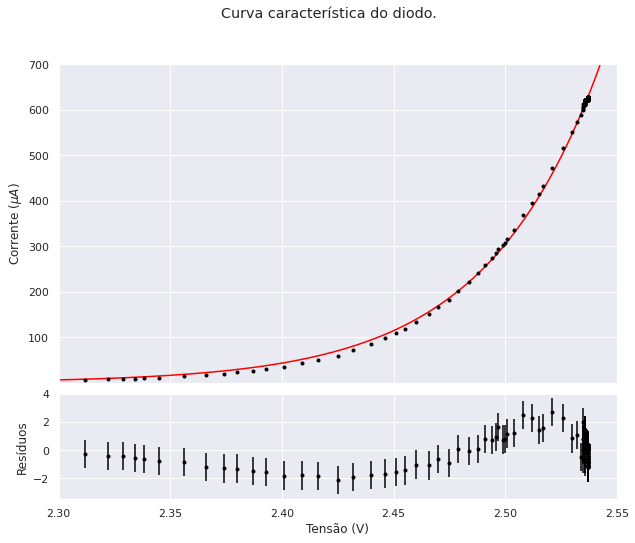

In [176]:
fig, axs = plt.subplots(2, sharex=True, gridspec_kw={ 'height_ratios': (3,1), 'hspace': 0.05 })
plt.suptitle('Curva característica do diodo.')


axs[0].errorbar(
	x=df_fit['Tensao B'],
	y=df_fit['Corrente'] * 1E6,
	xerr=df_fit['sTensao B'],
	yerr=df_fit['sCorrente'],
	fmt=' ', marker='.', color='black'
)

x = np.linspace(0, 2.6, 1000)
sns.lineplot(x=x, y=(popt[0] * (np.exp(popt[1] * x) - 1))*1E6, color='red', ax=axs[0])

axs[1].errorbar(
	x=df_fit['Tensao B'],
	y=(df_fit['Corrente'] - popt[0]*(np.exp(popt[1]*df_fit['Tensao B']) - 1))  / df_fit['sCorrente'],
	xerr=df_fit['sTensao B'],
	yerr=1,
	fmt=' ', marker='.', color='black'
)

axs[0].set_ylabel('Corrente ($\mu A$)')
axs[0].set_xlim(2.30, 2.55)
axs[0].set_ylim(1E-1, 0.7E3)

axs[1].set_ylabel('Resíduos')
axs[1].set_xlabel('Tensão (V)')

plt.show()

In [177]:
e/(k*popt[1]) - 273

320.3190633679212

In [178]:
np.sum( ( df_fit['Corrente'] - popt[0]*(np.exp(popt[1]*df_fit['Tensao B'])-1) )**2/ (df_fit['sCorrente'])**2 ) / df_fit.shape[0]

0.9835009990062942

## Painel Solar

In [65]:
df_painel = pd.read_csv('./Dados/painel_solar.csv')

In [66]:
df_painel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 779 entries, 0 to 778
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Tempo     779 non-null    float64
 1   Tensao A  779 non-null    float64
 2   Tensao B  779 non-null    float64
 3   Corrente  779 non-null    float64
dtypes: float64(4)
memory usage: 24.5 KB


In [67]:
R = 4.7, 0.05

In [68]:
df_painel['Corrente'] = df_painel['Tensao A'] / R[0]

/home/ivfreire/.local/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


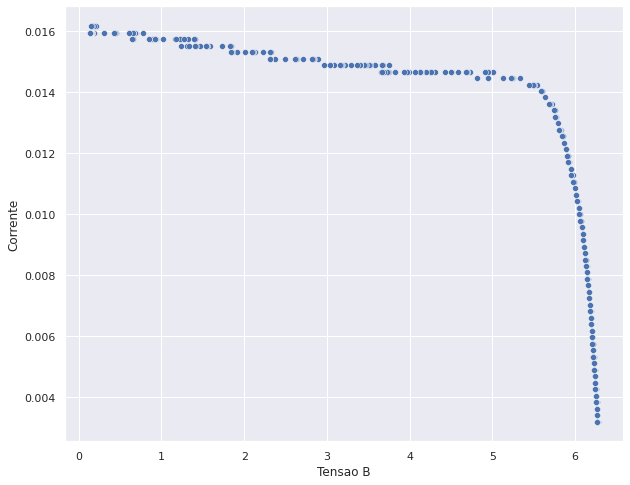

In [70]:
sns.scatterplot(df_painel['Tensao B'], df_painel['Corrente'])
plt.show()